In [2]:
import numpy as np

import pandas as pd

import xarray as xr

import glob

import matplotlib as mpl

import matplotlib.pyplot as plt

import math as mt

from math import e

import datetime

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from random import seed
from random import randint

from scipy.signal import hilbert
import statistics
from scipy.stats import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pickle
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from time import time
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import BayesianRidge

In [3]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])


In [4]:
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
# fogData.fogdata.values.shape
# fogData.stations
#plt.figure(figsize=[16,8])
#fg.fogdata.resample(time="1y").sum().sum(dim='stations').plot()
#fg.fogdata.time    

In [5]:
t2mData = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_t2m_3hourly_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_u10_3hourly_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_v10_3hourly_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_d2m_3hourly_NovDecJan.nc')
t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
u10D = u10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
v10D = v10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
d2mD = d2mData.sel(latitude=slice(32,24),longitude=slice(74,86))

In [6]:
# Calculate wind speed and relative humidity

ws = ((v10D.v10[:,0,:,:].values**2)+(u10D.u10[:,0,:,:].values**2))**0.5

ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

rh = (e**((17.625*(d2mD.d2m[:,0,:,:].values-273.15))/(243.04+(d2mD.d2m[:,0,:,:].values-273.15)))/e**((17.625*(t2mD.t2m[:,0,:,:].values-273.15))/(243.04+(t2mD.t2m[:,0,:,:].values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

#rh_ds


In [7]:
# Read 850 data

tz850Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_850_tqz_3hourly_NovDecJan.nc')

uv850Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_850_uv_3hourly_NovDecJan.nc')

tz850D = tz850Data.sel(latitude=slice(32,24),longitude=slice(74,86))

uv850D = uv850Data.sel(latitude=slice(32,24),longitude=slice(74,86))

In [8]:
#Calculate inv

inv=t2mD.t2m[:,0,:,:].values-tz850D.t[:,0,:,:].values

inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

inv_ds.attrs

inv_ds.attrs['units']='K'

inv_ds.attrs['long_name']='t2m - t850'

#inv_ds.inv

In [9]:
#u shear calculation

ushear=(uv850D.u[:,0,:,:].values-u10D.u10[:,0,:,:].values)/(tz850D.z[:,0,:,:].values/9.81) 

ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

ushear_ds.attrs['units']='s-1'

ushear_ds.attrs['long_name']='(u10 - u850)/z850'

In [10]:

w700Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_700_w_3hourly_NovDecJan.nc')

w700D = w700Data.sel(latitude=slice(32,24),longitude=slice(74,86))

# Read Orography

OroData = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/ERA5IGP_Orography.nc')

OroData.data_vars

OroD = OroData.sel(latitude=slice(32,24),longitude=slice(74,86))

oro = OroD.z

oro.values = OroD.z.values/9.81

oro.attrs

oro.attrs['units']='meter'

oro.attrs['long_name']='Orography'

l = np.arange(0,1000,100)

#oro[0,:,:].plot(levels=l,extend='both',cmap='jet')

In [11]:
# Create Mask altitude >500 m NaN

oro.values[oro.values>500.1]=np.NaN

mask=oro.values/oro.values

# chk mask

t2mD.t2m.values=t2mD.t2m.values*mask

#t2mData.t2m[0,0,:,:].plot(cmap='jet')

#plt.figure(figsize=[20,10])

#t2mData.mean(dim=['latitude','longitude']).t2m[:,0].plot()

t2mTS=t2mD.mean(dim=['latitude','longitude'], skipna=True).t2m[:,0]

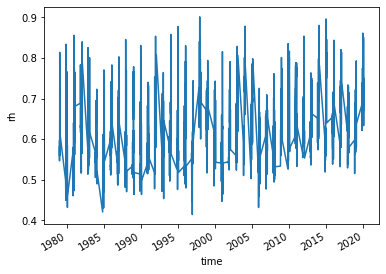

In [12]:
ws_ds.ws.values=ws_ds.ws.values*mask
wsTS=ws_ds.mean(dim=['latitude','longitude'], skipna=True).ws
#wsTS.plot()
rh_ds.rh.values=rh_ds.rh.values*mask
#rh_ds.rh[:].mean(dim=['latitude','longitude'], skipna=True).plot()
rhTS=rh_ds.mean(dim=['latitude','longitude'], skipna=True).rh
rhTS.plot()
w700D.w.values=w700D.w.values*mask
w700D.mean(dim=['latitude','longitude'])
wTS=w700D.mean(dim=['latitude','longitude'], skipna=True).w[:,0]
#wTS.plot()
inv_ds.inv.values=inv_ds.inv.values*mask
invTS=inv_ds.mean(dim=['latitude','longitude'], skipna=True).inv
#invTS.plot()
ushear_ds.ushear.values=ushear_ds.ushear.values*mask
ushearTS=ushear_ds.mean(dim=['latitude','longitude'], skipna=True).ushear
#ushearTS.plot()
#Create area averaged values and get same days as fog days i.e. Dec Jan

# a,b = xr.align(fg.fogdata.sum(dim='stations'),t2mTS)

t2m=t2mTS[((t2mTS.time.dt.month>11) | (t2mTS.time.dt.month<2)) & (t2mTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))

ws=wsTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))

inv=invTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))

rh=rhTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))

w=wTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))

ushear=ushearTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'))

#t2m

In [13]:

X       = pd.DataFrame([t2m.values,ws.values,rh.values,inv.values,w.values,ushear.values*100.0]).T[:]


X.index = pd.to_datetime(t2m.time.values)
X

,0,1,2,3,4,5
1980-01-01 10:30:00,288.873718,2.103235,0.752254,5.917946,-0.153306,0.267513
1980-01-02 10:30:00,288.148560,1.536837,0.766426,6.877218,-0.033940,0.140727
1980-01-03 10:30:00,286.932129,1.963692,0.752228,6.723764,0.075506,0.069107
1980-01-04 10:30:00,285.958344,1.931438,0.724486,5.591223,0.035796,0.041987
1980-01-05 10:30:00,286.157257,1.960673,0.686824,4.766602,0.048788,0.153410
...,...,...,...,...,...,...
2014-12-27 10:30:00,285.193542,1.280519,0.695126,2.306709,0.087841,0.103375
2014-12-28 10:30:00,284.691315,1.395883,0.724894,0.527306,0.032342,-0.090063
2014-12-29 10:30:00,284.454742,1.371714,0.760787,0.038587,-0.016428,-0.146703
2014-12-30 10:30:00,284.399414,1.474323,0.787351,0.568241,-0.085211,-0.119415


In [14]:
y=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2014-12-31'))
y=y/25.0
y

<xarray.DataArray 'fogdata' (time: 2170)>
array([0.32, 0.4 , 0.4 , ..., 0.76, 0.72, 0.76])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2014-12-31

In [19]:
# build a classifier
gbReg = BayesianRidge( fit_intercept=False, compute_score=True)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
#=20, max_depth= 3,learning_rate=0.04,
param_dist = {'alpha_init':[0.0001,0.0005,0.001,0.005,0.1,0.5,1,5],
              'lambda_init': [0.0001,0.0005,0.001,0.005,0.1,0.5,1,5],
              'tol':[1e-6,1e-5,1e-3,1e-2,10,100],
              }

# run randomized search
n_iter_search = 20
#random_search = RandomizedSearchCV(gbReg, param_distributions=param_dist,
 #                                  n_iter=n_iter_search)
random_search = RandomizedSearchCV(gbReg, param_dist,scoring='r2')

start = time()
random_search.fit(X, y)
print("GridSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)


GridSearchCV took 6.63 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.202 (std: 0.222)
Parameters: {'tol': 100, 'lambda_init': 0.0001, 'alpha_init': 1}

Model with rank: 2
Mean validation score: 0.202 (std: 0.222)
Parameters: {'tol': 0.01, 'lambda_init': 0.1, 'alpha_init': 5}

Model with rank: 3
Mean validation score: 0.202 (std: 0.222)
Parameters: {'tol': 1e-06, 'lambda_init': 0.0005, 'alpha_init': 0.005}



Automatically created module for IPython interactive environment


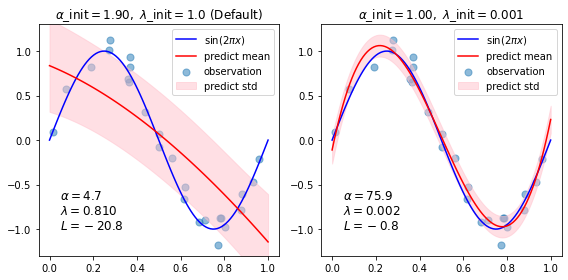

In [1]:
print(__doc__)

# Author: Yoshihiro Uchida <nimbus1after2a1sun7shower@gmail.com>

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import BayesianRidge


def func(x): return np.sin(2*np.pi*x)


# #############################################################################
# Generate sinusoidal data with noise
size = 25
rng = np.random.RandomState(1234)
x_train = rng.uniform(0., 1., size)
y_train = func(x_train) + rng.normal(scale=0.1, size=size)
x_test = np.linspace(0., 1., 100)


# #############################################################################
# Fit by cubic polynomial
n_order = 3
X_train = np.vander(x_train, n_order + 1, increasing=True)
X_test = np.vander(x_test, n_order + 1, increasing=True)

# #############################################################################
# Plot the true and predicted curves with log marginal likelihood (L)
reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i, ax in enumerate(axes):
    # Bayesian ridge regression with different initial value pairs
    if i == 0:
        init = [1 / np.var(y_train), 1.]  # Default values
    elif i == 1:
        init = [1., 1e-3]
        reg.set_params(alpha_init=init[0], lambda_init=init[1])
    reg.fit(X_train, y_train)
    ymean, ystd = reg.predict(X_test, return_std=True)

    ax.plot(x_test, func(x_test), color="blue", label="sin($2\\pi x$)")
    ax.scatter(x_train, y_train, s=50, alpha=0.5, label="observation")
    ax.plot(x_test, ymean, color="red", label="predict mean")
    ax.fill_between(x_test, ymean-ystd, ymean+ystd,
                    color="pink", alpha=0.5, label="predict std")
    ax.set_ylim(-1.3, 1.3)
    ax.legend()
    title = "$\\alpha$_init$={:.2f},\\ \\lambda$_init$={}$".format(
            init[0], init[1])
    if i == 0:
        title += " (Default)"
    ax.set_title(title, fontsize=12)
    text = "$\\alpha={:.1f}$\n$\\lambda={:.3f}$\n$L={:.1f}$".format(
           reg.alpha_, reg.lambda_, reg.scores_[-1])
    ax.text(0.05, -1.0, text, fontsize=12)

plt.tight_layout()
plt.show()